# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
•	сalls — количество звонков,
•	minutes — суммарная длительность звонков в минутах,
•	messages — количество sms-сообщений,
•	mb_used — израсходованный интернет-трафик в Мб,
•	is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Оглавление:** <a id="toc"></a>
1. [Откроем и изучим файл](#15)
2. [Разобьем данные на выборки](#25)
3. [Исследуем модели](#35)
4. [Проверим модели на тестовой выборке](#45)
5. [Проверим модели на адекватность](#55)


## Откройте и изучите файл <a id="15"></a>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
#import warnings
#warnings.simplefilter('ignore')

# будем отображать только 2 знака после запятой
pd.set_option("precision", 2)

In [3]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/users_behavior.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В датасэте 3214 записей, пропусков нет , 

In [5]:
display(df.tail())

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


In [6]:
# проверим есть ли дубликаты
df.duplicated().sum()

0

In [7]:
# проверим, есть ли в датасэте отридцательные значения
(df.values < 0).any()

False

In [8]:
# заметим, что есть нулевые значения. Посмотрим сколько их.
for column in df.columns:
    if column!= 'is_ultra':
        print('В столбце {} нулевых значений'.format(column))
        print(df[df[column]==0]['calls'].count())    

В столбце calls нулевых значений
40
В столбце minutes нулевых значений
40
В столбце messages нулевых значений
497
В столбце mb_used нулевых значений
11


В некоторых месяцах абоненты не звонили и не пользовались интернетом. Но таких мало.
Но намного больше тех кто не отправлял ни одной смс в месяц.

In [9]:
df['is_ultra'] = df['is_ultra'].astype('bool')

In [10]:
df.describe(include=['float64','bool'])

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,2229
mean,63.04,438.21,38.28,17207.67,NaN
std,33.24,234.57,36.15,7570.97,NaN
min,0.00,0.00,0.00,0.00,NaN
25%,40.00,274.58,9.00,12491.90,NaN
50%,62.00,430.60,30.00,16943.24,NaN
75%,82.00,571.93,57.00,21424.70,NaN


Проведем краткую статистическую оценку:
- `calls` Среднее почти совпадает с медианой. Есть надежда что распределение нормальное. СКО 33, довольно высокое при среднем 63. Данные вполне адекватны за месяц можно сделать 244 звонка.
- `minutes` Среднее почти совпадает с медианой. Есть надежда что распределение нормальное. СКО 234, довольно высокое при среднем 430. Данные вполне адекватны за месяц можно проговорить 1632 минуты. Хотя это почти целый час в день.
- `messages` Среднее почти не совсем с медианой. СКО большое 36, очень высокое при среднем 38. Данные вполне адекватны за месяц можно послать 244 смс.
- `mb_used` Среднее почти совпадает с медианой. Есть надежда что распределение нормальное. СКО 7,5 гб, довольно высокое при среднем 17 гб. Данные вполне адекватны за месяц можно потратить 49 гигабайт.

данные обрезать не будем, т.к при изменение выборки сможет нам помешать добиться высокой точности и противоречит заданию

In [11]:
df['is_ultra'].value_counts(normalize=True)

False    0.69
True     0.31
Name: is_ultra, dtype: float64

Ввыбрке в основном представлены пользователи с тарифом 'Smart'

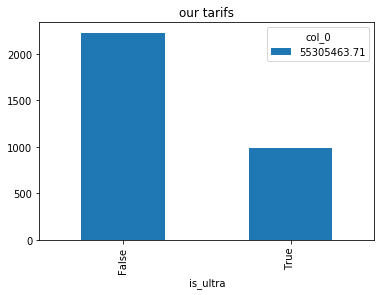

In [12]:
pd.crosstab(df['is_ultra'], df['mb_used'].sum()).plot(kind='bar',label = 'tarif',legend=True);
plt.title('our tarifs');

In [13]:
df['is_ultra'].value_counts(normalize =True)

False    0.69
True     0.31
Name: is_ultra, dtype: float64

In [14]:
list(set(df.columns)-set(['is_ultra']))

['calls', 'minutes', 'mb_used', 'messages']

In [15]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.00,0.98,0.18,0.29,0.21
minutes,0.98,1.00,0.17,0.28,0.21
messages,0.18,0.17,1.00,0.20,0.20
mb_used,0.29,0.28,0.20,1.00,0.20
is_ultra,0.21,0.21,0.20,0.20,1.00


In [16]:
df.corr(method='spearman')

,calls,minutes,messages,mb_used,is_ultra
calls,1.00,0.98,0.16,0.25,0.16
minutes,0.98,1.00,0.15,0.25,0.16
messages,0.16,0.15,1.00,0.14,0.11
mb_used,0.25,0.25,0.14,1.00,0.15
is_ultra,0.16,0.16,0.11,0.15,1.00


In [17]:
df.corr(method='kendall')

,calls,minutes,messages,mb_used,is_ultra
calls,1.00,0.88,0.11,0.18,0.13
minutes,0.88,1.00,0.11,0.17,0.13
messages,0.11,0.11,1.00,0.10,0.09
mb_used,0.18,0.17,0.10,1.00,0.13
is_ultra,0.13,0.13,0.09,0.13,1.00


## Разбейте данные на выборки <a id="25"></a>

In [18]:
from sklearn.model_selection import train_test_split
df_train,df_test_valid = train_test_split(df,test_size=0.4,random_state=890)

In [19]:
# проверим, корректно ли поделились наши выборки
def test_percent(df1,df2):
    p1=df1.shape[0]/df.shape[0]
    p2 = df2.shape[0]/df.shape[0]
    print('{:.0%} {:.0%}'.format(p1,p2))
test_percent(df_train,df_test_valid)

60% 40%


In [20]:
#поделим тестовую и валидационную выборки пополам
df_test,df_valid = train_test_split(df_test_valid,test_size=0.5,random_state=890)
test_percent(df_test,df_valid)

20% 20%


In [21]:
#проверим стратификацию поделенных выборок
# не наблюдается ли перекоса
def ratio_ultra(_df):
    print(_df.shape[0])
    _df=df_test['is_ultra'].value_counts(normalize=True)
    _list = []
    _list.append([_df.iloc[0],_df.iloc[1]])
    print(_list)
ratio_ultra(df_train) 
ratio_ultra(df_test)  
ratio_ultra(df_valid) 

1928
[[0.6889580093312597, 0.3110419906687403]]
643
[[0.6889580093312597, 0.3110419906687403]]
643
[[0.6889580093312597, 0.3110419906687403]]


Все впорядке, модели поделились корректно.

In [22]:
#подготовим выборки для загрузки в модель
# по этим данным будут учится наши модели. 
#Далее будем считать точность прогноза,сравнивая с исходными выборками
train_features = df_train.drop('is_ultra',axis=1)
train_target = df_train['is_ultra']

valid_features = df_valid.drop('is_ultra',axis=1)
valid_target = df_valid['is_ultra']

test_features = df_test.drop('is_ultra',axis=1)
test_target = df_test['is_ultra']

#подготовим данные для кросс валидации
cv_features = df.drop('is_ultra',axis=1)
cv_target = df['is_ultra']

## Исследуйте модели <a id="35"></a>

**DecisionTreeClassifier**

In [23]:
# создадим модель "Дерево решений"
accuracy_valid_dict_DT={}
accuracy_test_dict_DT={}
for depth in range (1,50):
    model_DT = DecisionTreeClassifier(random_state=890,max_depth=depth)
    model_DT.fit(train_features,train_target)
    #на валидационной
    valid_predict = model_DT.predict(valid_features)
    accuracy_valid = accuracy_score(valid_predict,valid_target)
    accuracy_valid_dict_DT[depth]=accuracy_valid
    #на тестовой
    test_predict = model_DT.predict(test_features)
    accuracy_test = accuracy_score(test_predict,test_target)
    accuracy_test_dict_DT[depth]=accuracy_test

,0
3,0.81
2,0.79
9,0.79
4,0.79
6,0.79


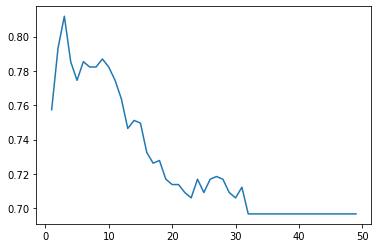

In [24]:
def draw_accuracy_DT(accuracy_dict):
    global df1
    df1 = pd.DataFrame.from_dict(accuracy_dict,orient='index')
    display(df1.sort_values(by=df1.columns[0],ascending=False ).head())
    #display(df1[df.columns[0]].max())
draw_accuracy_DT(accuracy_valid_dict_DT)
ax1= plt.plot(df1)

При обучении модели "Дерево решений" `DecisionTreeClassifier` и тестирования на валидационной выборке заметили небольшое повышение качества классификации абонента с глубиной дерева 3, но дальше видим неизбежный спад. В данном случае мне кажется качество не повышается, т.к. мало признаков и дереву не откуда брать комбинации по условиям. А при глубине дерева в 32 качество перестает снижаться и модель перестает учиться совсем. Возможно подбор других гиперпараметров поможет нам.

In [25]:
model_tree = DecisionTreeClassifier(random_state=890,max_depth=3)
model_tree.fit(train_features,train_target)
train_features.columns
export_graphviz(model_tree, feature_names=['calls', 'minutes', 'messages', 'mb_used'], 
out_file='./img/deep_toy_tree.dot', filled=True)
#!dot -Tpng './img/deep_toy_tree.dot' -o './img/deep_toy_tree.png'

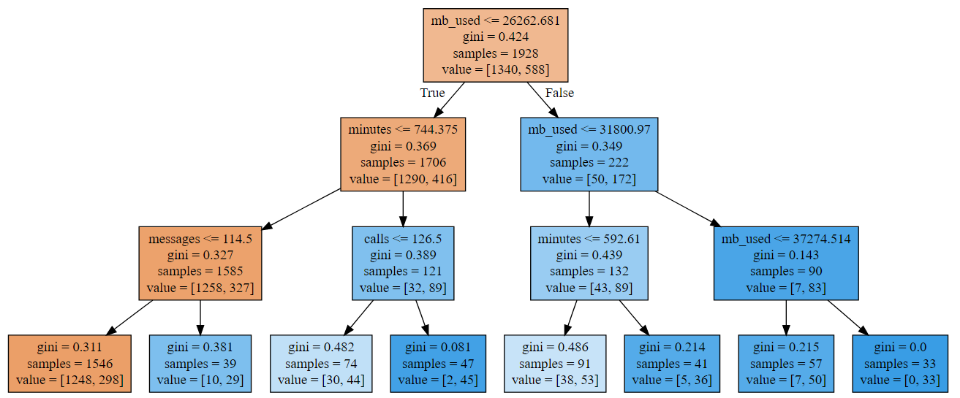

In [26]:
# мы построили дерево онлайн 
from IPython import display
display.Image("https://b.radikal.ru/b01/2103/0f/8e5c4af9b3b4.png")
#display.Image("./sdv_featured_image.png")

В данноый модели у нас есть 4 признака `['calls', 'minutes', 'messages', 'mb_used']` по которым строится дерево решений. Методом перебора мы ранее определили что с глубиной 3 качество модели `accurancy` на валидационной выборке показало максимальный результат.
-  На выходе мы получили 8 условных классов, в один из которых будет попадать новый элемент из валидационной выборки, когда мы будем проводить валидацию.
- Классы разделены цветом - оранжевый `ultra`, голубой `smart`. Как мы видим еще есть светло-голубые цвета, это значит что модель на данном уровне декомпозиции не может принять однозначного решения и на следующем листе может быть уточнение. Но декомпозиция вглубь может привести к переобучению выборки на тестовых данных и снизит качество модели.
- В скобках указаны количество объектов в каждом классе`[ultra,smart]`после классификации. Т.е. изначально в выборке соотношение [1340,588] На основании пары объектов`[ultra,smart]`  считается критерий`gini` неопределенность (энтропия), которую уменьшает правило разбиения `mb_used <= 26262.681` и мы получаем новые 2 подклассы. Напирмер в листе дерева [0,33] неопределенность равна нулю, т.е. все объекты по данному дереву решений из тренировочной выборки были отнесены к тарифу `smart`. Чем меньше неопределенность - тем лучше, но не будем забывать о переобучении, т.к. на валидационной и тестовой выборке на существующем дереве мы получим другие коэфициенты `gini`, хотя правила останутся теми же.
- Ну и самое главное это правила по которым формируется дерево. Напомним, у нас есть 4 признака `['calls', 'minutes', 'messages', 'mb_used']`. Дерево решений строится исходя из критерия `gini`. Берется комбинация признаков и их значений и подбирается такой критерий `gini`, который максимально уменьшает неопределенность. Т.е `mb_used <= 26262.681` в выборке будет самым важным критерием, разделяющих поведение абонентов.
- Далее в вершине дерева создаются 2 новых класса и опять ищем критерий, который максимально снизит неопределенность, т.е. при какой комбинации признаков и их значений критерий `gini` будет самый высокий для данной подвыборки. В следующих двух вершинах ужен берутся други признаки и их значения `minutes <= 744.375`  и `mb_used <= 31800.97` по которым строятся новые потомки дерева и т.д. пока не достигнем заявленной глубины.

**KNeighborsClassifier**

In [27]:
from sklearn.model_selection import cross_val_score
neigbors = list(range(1,20)) +list(range(20,100,5))
from sklearn.neighbors import KNeighborsClassifier
neighbors_list = []
for neighbor in neigbors:
    knn_model = KNeighborsClassifier(n_neighbors =neighbor )
    #hold-out(отложенная выборка)
    knn_model.fit(train_features,train_target)
    valid_predict_KNN = knn_model.predict(valid_features)
    accuracy_valid = accuracy_score(valid_predict_KNN,valid_target)
    #cv - cross-validation(k-fold validation) на всей выборке и на тренировочной
    cross_valid_knn_total = np.mean(cross_val_score(knn_model,cv_features,cv_target,cv=10))
    cross_valid_knn = np.mean(cross_val_score(knn_model,train_features,train_target,cv=10))
    #append
    neighbors_list.append([neighbor,accuracy_valid,cross_valid_knn_total,cross_valid_knn])
df_neigbors = pd.DataFrame(neighbors_list,columns=['neighbor','accuracy_valid','cross_valid_knn_total','cross_valid_knn'])
_accuracy_valid =df_neigbors.sort_values(by='accuracy_valid',ascending=False).head(1).loc[:,['neighbor','accuracy_valid']]
print('Максимальное accuracy {:.2%} достигается при параметре n_neighbors = {:.0f} на отложенной выборке'\
      .format(_accuracy_valid.values[0][1],_accuracy_valid.values[0][0]))


Максимальное accuracy 77.76% достигается при параметре n_neighbors = 13 на отложенной выборке


**RandomForestClassifier**

In [28]:
# попробуем обучить модель "случайный лес" для предсказания тарифа

In [29]:
%%time 
from sklearn.ensemble import RandomForestClassifier
score_valid_dict_RFC={}
score_test_dict_RFC={}
score_valid_list = []
score_test_list = []
for depth in range(8,14):
    for est in range(1, 70,5):#(1, 200,5)
        model_RFC = RandomForestClassifier(random_state=890,\
                                           n_estimators=est,max_depth=depth)
        model_RFC.fit(train_features,train_target)
        #valid_predict = model_RFC.predict(valid_features)
        score_valid = model_RFC.score(valid_features,valid_target)
        score_test = model_RFC.score(test_features,test_target)
        #запишем в словарь
        #score_valid_dict_RFC[est]=score_valid
        #score_test_dict_RFC[est]=score_test
        score_valid_list.append([est,depth,score_valid])
        score_test_list.append([est,depth,score_test])
#print(score_valid_dict_RFC,score_test_dict_RFC)

CPU times: user 11.8 s, sys: 54.8 ms, total: 11.8 s
Wall time: 13.4 s


In [30]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(valid_predict_KNN ,valid_target)

In [31]:
from IPython.display import display
#df3 =pd.DataFrame(score_valid_list).sort_values(by =df3.columns[2],ascending=False).head()
df1 =pd.DataFrame(score_valid_list)
df1.set_axis(['est','depth','score'],axis=1,inplace=True)
#посмотрим в каком разрезе нам строить графики
#с какими типами гиперпараметров мы получили больше качественных моделей
display(df1.sort_values(by ='score',ascending=False).head(10)['est'].value_counts())
display(df1.sort_values(by ='score',ascending=False).head(30)['depth'].value_counts())
display(df1.sort_values(by='score',ascending=False).head(10))



51    3
56    2
46    1
61    1
41    1
36    1
66    1
Name: est, dtype: int64

9     9
10    8
8     5
13    4
11    4
Name: depth, dtype: int64

,est,depth,score
25,56,9,0.84
24,51,9,0.84
37,46,10,0.83
38,51,10,0.83
22,41,9,0.83
39,56,10,0.83
35,36,10,0.83
27,66,9,0.83
40,61,10,0.83
10,51,8,0.83


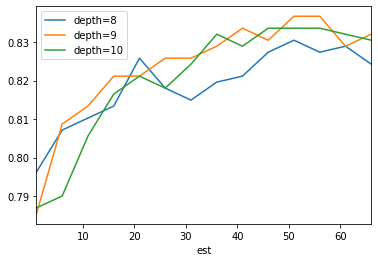

Максимальная точность, которую мы смогли получить с помощью алгоритма случайный лес 83.67% 


In [32]:
# для анализа мы выбрали разрез по глубине деревьев
# заметим что в основном большая точность у деревьев с глубиной 8,9,10

ax1 = df1.query('depth==8').plot(x='est',y='score',kind='line',label='depth=8');
ax2 = df1.query('depth==9').plot(x='est',y='score',kind='line',ax=ax1,label='depth=9');    
ax2 = df1.query('depth==10').plot(x='est',y='score',kind='line',ax=ax1,label='depth=10');
plt.show()
print('Максимальная точность, которую мы смогли получить с помощью алгоритма случайный лес {:.2%} '\
      .format(df1['score'].max()))


Как мы видим при количестве деревьев в лесу `n_estimator` в районе 35-60 модель выдает лучшие показания по качеству `accuracy` 

**LogisticRegression**

In [33]:
accuracy_test_dict_LR = {}
accuracy_valid_dict_LR = {}

model_LR = LogisticRegression(random_state=890)
model_LR.fit(train_features,train_target);
valid_predict = model_LR.predict(valid_features)
#на валидационной
valid_predict = model_LR.predict(valid_features)
accuracy_valid_LR = accuracy_score(valid_predict,valid_target)
#accuracy_test_dict_LR[depth]=accuracy_valid
#на тестовой
test_predict = model_LR.predict(test_features)
accuracy_test_LR = accuracy_score(test_predict,test_target)
#accuracy_valid_dict_LR[depth]=accuracy_test

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
print('Качество на валидационной выборке {:.2%}'
      .format(accuracy_valid_LR))

Качество на валидационной выборке 74.49%


## Проверьте модель на тестовой выборке <a id="45"></a>

**DecisionTreeClassifier**

,0
6,0.79
7,0.79
10,0.79
5,0.79
9,0.79


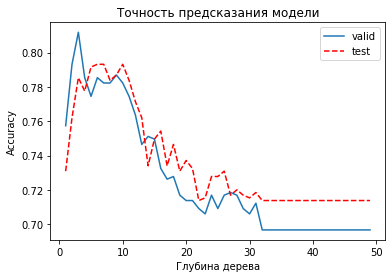

In [35]:
#посмотрим точность на тестовой выборке
draw_accuracy_DT(accuracy_test_dict_DT)
#подготовим данные по accuracy на тестовых и валидационных выборках
df1 = pd.DataFrame.from_dict(accuracy_valid_dict_DT,orient='index')
df2 = pd.DataFrame.from_dict(accuracy_test_dict_DT,orient='index')
#построим график
plt.plot(df1)
plt.plot(df2,'r--')
plt.title('Точность предсказания модели')
plt.xlabel('Глубина дерева');
plt.ylabel('Accuracy');
plt.legend(['valid','test']);

График схож с валидационной, но здесь мы не достигаем высокой точности предсказания, как на валидационной выборке. Как мы видим, переобучение модели сдесь тоже наступает при глубине дерева более 12.

**KNeighborsClassifier**

In [36]:
_accuracy_valid =df_neigbors.sort_values(by='accuracy_valid',ascending=False).head(1).loc[:,['neighbor','accuracy_valid']]
print('Максимальное accuracy {:.2%} достигается при параметре n_neighbors = {:.0f} на отложенной выборке'\
      .format(_accuracy_valid.values[0][1],_accuracy_valid.values[0][0]))
_accuracy_valid =df_neigbors.sort_values(by='cross_valid_knn_total',ascending=False).head(1).loc[:,['neighbor','cross_valid_knn_total']]
print('Максимальное accuracy {:.2%} достигается при параметре n_neighbors = {:.0f} при кросс валидации на всех данных'\
      .format(_accuracy_valid.values[0][1],_accuracy_valid.values[0][0]))
_accuracy_valid =df_neigbors.sort_values(by='cross_valid_knn',ascending=False).head(1).loc[:,['neighbor','cross_valid_knn']]
print('Максимальное accuracy {:.2%} достигается при параметре n_neighbors = {:.0f} при кросс валидации только на тренировочных данных'\
      .format(_accuracy_valid.values[0][1],_accuracy_valid.values[0][0]))
#print('Максимальное accuracy для ТОП-3 элементов при кросс валидации на всех данных  ')
#display(df_neigbors.sort_values(by='cross_valid_knn_total',ascending=False).head(3).loc[:,['cross_valid_knn_total']])
#print('Максимальное accuracy для ТОП-3 элементов при кросс валидации только на тренировочных данных ')
#display(df_neigbors.sort_values(by='cross_valid_knn',ascending=False).head(3).loc[:,['neighbor','cross_valid_knn']])

Максимальное accuracy 77.76% достигается при параметре n_neighbors = 13 на отложенной выборке
Максимальное accuracy 77.10% достигается при параметре n_neighbors = 8 при кросс валидации на всех данных
Максимальное accuracy 76.82% достигается при параметре n_neighbors = 11 при кросс валидации только на тренировочных данных


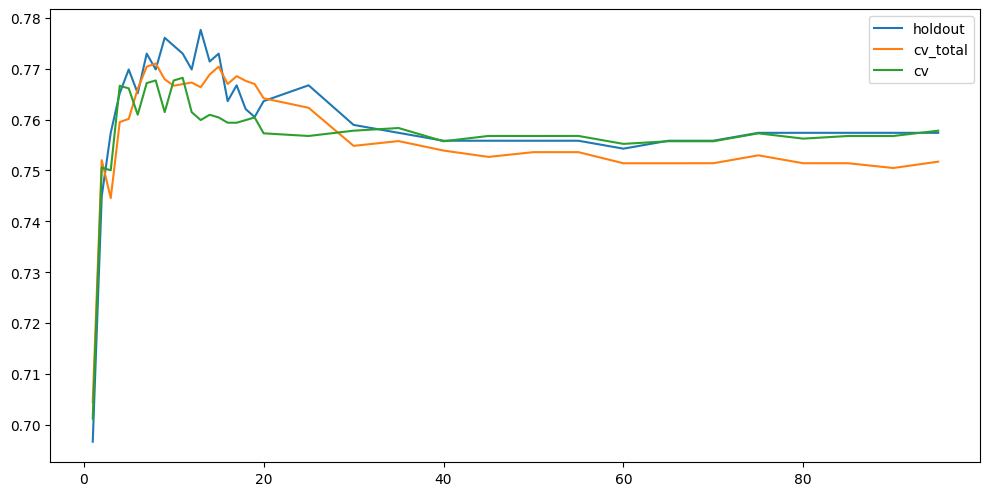

In [37]:
#df_neigbors = df_neigbors.iloc[:,1:2]
#print(df_neigbors['index'])
plt.figure(figsize=(12,6),dpi=100);
plt.plot(df_neigbors['neighbor'],df_neigbors['accuracy_valid'],label = 'holdout');
plt.plot(df_neigbors['neighbor'],df_neigbors['cross_valid_knn_total'],label = 'cv_total');
plt.plot(df_neigbors['neighbor'],df_neigbors['cross_valid_knn'],label = 'cv');
plt.legend();

Используем для задачи классификации метод ближайших соседей в модели мы перебрали гиперпараметр `n_neighbors` и посмотрели как вдет себя модель при кросс валидации и отложенной выборках и получили следующие результаты:
- Максимальное accuracy 77.76% достигается при параметре n_neighbors = 13 на отложенной выборке
- Максимальное accuracy 76.70% достигается при параметре n_neighbors = 15 при кросс валидации на всех данных
- Максимальное accuracy 76.87% достигается при параметре n_neighbors = 8 при кросс валидации только на тренировочных данных

Как видим, если классификация тарифа происходит по 8-15 соседям, алгоритм выдает наиболее качественную модель.
Но по сравнению с другими алгоритмами он не дал высокой точности, т.к. мы не нормировали признаки, назначив коэфициенты признакам

**LogisticRegression**

In [38]:
print('Качество модели "Логистическая регрессия" на тестовой выборке равна {:.2%}'
      .format(accuracy_test_LR))


Качество модели "Логистическая регрессия" на тестовой выборке равна 74.18%


Т.к. у логистической регрессии в модели мало параметров , то она работает быстро, но точность у нее небольшая. .....

**RandomForestClassifier**

In [39]:
df2 =pd.DataFrame(score_test_list)
df2.set_axis(['est','depth','score'],axis=1,inplace=True)
print(df2.sort_values(by='score',ascending=False).head(1))
print('Качество модели случайный лес на тестовой выборке равно {:.2%}'.\
      format(df2.score.max()))

    est  depth  score
83   66     13   0.83
Качество модели случайный лес на тестовой выборке равно 83.05%


__Общий вывод:__
- Качество модели "Дерево решений" на тестовой выборке равна 79.32%
- Качество модели "Логистическая регрессия" на тестовой выборке равна 74.18%
- Качество модели "Случайный лес" на тестовой выборке равно  83.05%
 
Качество моделей на тестовой выборке , меньше чем на валидационной. Немного непонятно с чем это связано.


## Проверим модели на адекватность <a id="55"></a>

Сравненим модели с dummyClassifier  необходимо чтобы понять, что наша модель не хуже чем примитивная модель. Нужно узнать,что точность модели не близка к случайной, возможно мы некорректнно подобрали гиперпараметры или выбрали саму модель для данной задачи.

In [40]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='stratified', random_state=890)
clf.fit(train_features,train_target)
#print(clf.get_params())
print('Качество на примитивной модели на данной выборке равно: %.2f'%clf.score(valid_predict,valid_target))

Качество на примитивной модели на данной выборке равно: 0.60


Качество модели ``RandomForestClassifier`` превышает качество модели ``DummyClassifier`` поэтому мы смело можем предполагать что наша модель эффективней, чем просто случайно назначать пользователю один из тарифов.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
